In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns

## spearman r correlation plots + distribution

In [2]:
# create dataframe of ranked pairs from ESM contact matrix
def df_from_esm_contact_matrix(contact_matrix):
    
    gather = []
    
    # traverse over upper right triangle, exlucding main diagonal
    for i in range(contact_matrix.shape[0]):
        for j in range(i+1, contact_matrix.shape[1]):
            # SANITY check the matrix should be symmetric
            assert contact_matrix[i][j] == contact_matrix[j][i]

            row_dict = dict(
                i = i,
                j = j,
                prob = contact_matrix[i,j]
            )
            
            gather.append(row_dict)

    return pd.DataFrame(gather)

In [3]:
# load esm_data
esm_results_path = os.path.join('..', 'results/cadherin/esmfold/results.zip')
esm_results = np.load(esm_results_path)
job_name = 'cadherin'

#number of sequences in Cadherin MSA
num_seqs = 55

esm_dfs = []
for i in range(num_seqs):
    # index into NPzFile object with file name
    contact_matrix = esm_results[f'{i}_{job_name}']
    df = df_from_esm_contact_matrix(contact_matrix)
    # display(df)
    esm_dfs.append(df)
    
# for i in range(len(esm_dfs)):
#     esm_dfs[i] = df.sort_values(by="prob", ascending=False).reset_index(drop=True)

In [ ]:
# load mapped dca outputs
cols = ['protein_idx', 'protein_id', 'msa_i', 'msa_j', 'seq_i', 'seq_j', 'dca_score']

df_mfdca_all = pd.read_csv('../data/cadherin/PF00028_mfdca_mapped.csv', header=None)
df_mfdca_all.columns = cols
# df_mfdca_all['seq_i'] = df_mfdca_all['seq_i'].astype(int)
# df_mfdca_all['seq_j'] = df_mfdca_all['seq_j'].astype(int)

df_plmdca_all = pd.read_csv('../data/cadherin/PF00028_plmdca_mapped.csv', header=None)
df_plmdca_all.columns = cols
# df_plmdca_all['seq_i'] = df_plmdca_all['seq_i'].astype(int)
# df_plmdca_all['seq_j'] = df_plmdca_all['seq_j'].astype(int)

In [5]:
df_mfdca_all[:5]

,protein_idx,protein_id,msa_i,msa_j,seq_i,seq_j,dca_score
0,0,DSC2_BOVIN/428-517,0.0,1.0,0.0,1.0,0.028504
1,0,DSC2_BOVIN/428-517,0.0,2.0,0.0,2.0,0.059369
2,0,DSC2_BOVIN/428-517,0.0,3.0,0.0,3.0,0.034621
3,0,DSC2_BOVIN/428-517,0.0,4.0,0.0,4.0,0.037939
4,0,DSC2_BOVIN/428-517,0.0,5.0,0.0,5.0,0.032860


In [6]:
df_mfdca_all[df_mfdca_all['seq_i'] == 0]

,protein_idx,protein_id,msa_i,msa_j,seq_i,seq_j,dca_score
0,0,DSC2_BOVIN/428-517,0.0,1.0,0.0,1.0,0.028504
1,0,DSC2_BOVIN/428-517,0.0,2.0,0.0,2.0,0.059369
2,0,DSC2_BOVIN/428-517,0.0,3.0,0.0,3.0,0.034621
3,0,DSC2_BOVIN/428-517,0.0,4.0,0.0,4.0,0.037939
4,0,DSC2_BOVIN/428-517,0.0,5.0,0.0,5.0,0.032860
...,...,...,...,...,...,...,...
240544,54,CAD13_CHICK/368-469,0.0,124.0,0.0,97.0,0.051440
240545,54,CAD13_CHICK/368-469,0.0,125.0,0.0,98.0,0.051445
240546,54,CAD13_CHICK/368-469,0.0,126.0,0.0,99.0,0.056525
240547,54,CAD13_CHICK/368-469,0.0,127.0,0.0,100.0,0.023941


In [7]:
df_plmdca_all[:5]

,protein_idx,protein_id,msa_i,msa_j,seq_i,seq_j,dca_score
0,0,DSC2_BOVIN/428-517,22,24,19,21,0.103717
1,0,DSC2_BOVIN/428-517,71,72,52,53,0.092372
2,0,DSC2_BOVIN/428-517,71,73,52,54,0.089911
3,0,DSC2_BOVIN/428-517,72,73,53,54,0.081874
4,0,DSC2_BOVIN/428-517,40,41,34,35,0.074809


In [8]:
df.columns

Index(['i', 'j', 'prob'], dtype='object')

In [9]:
gather = []
for protein_idx in range(num_seqs):


    df_esm = esm_dfs[protein_idx]
    df_esm.loc[:, 'residue_pair'] = [(seq_i, seq_j) for seq_i,seq_j in zip(df_esm['i'], df_esm['j'])]

    df_plmdca = df_plmdca_all[df_plmdca_all['protein_idx'] == protein_idx]
    df_plmdca.loc[:, 'residue_pair'] = [(seq_i, seq_j) for seq_i,seq_j in zip(df_plmdca['seq_i'], df_plmdca['seq_j'])]

    df_mfdca = df_mfdca_all[df_mfdca_all['protein_idx'] == protein_idx]
    df_mfdca.loc[:, 'residue_pair'] = [(seq_i, seq_j) for seq_i,seq_j in zip(df_mfdca['seq_i'], df_mfdca['seq_j'])]
    
    # all i strictly less than j
    assert all(df_esm['i'] < df_esm['j'])
    assert all(df_plmdca['seq_i'] < df_plmdca['seq_j'])
    assert all(df_mfdca['seq_i'] < df_mfdca['seq_j'])

    # display(df_mfdca)

    df_esm_mfdca = pd.merge(df_esm, 
                        df_mfdca,
                        how = 'inner',
                        on = 'residue_pair')


    gather.append(dict(
        DCA_type = 'MF',
        spearman_r = spearmanr(df_esm_mfdca['dca_score'], df_esm_mfdca['prob']).statistic
    ))

    df_esm_plmdca = pd.merge(df_esm, 
                         df_plmdca,
                         how = 'inner',
                         on = 'residue_pair')

    gather.append(dict(
        DCA_type = 'PLM',
        spearman_r = spearmanr(df_esm_plmdca['dca_score'], df_esm_plmdca['prob']).statistic
    ))



/var/folders/9s/yxmqx5dj6rb86f2zsgmn5z2m0000gn/T/ipykernel_9125/3587096705.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plmdca.loc[:, 'residue_pair'] = [(seq_i, seq_j) for seq_i,seq_j in zip(df_plmdca['seq_i'], df_plmdca['seq_j'])]
/var/folders/9s/yxmqx5dj6rb86f2zsgmn5z2m0000gn/T/ipykernel_9125/3587096705.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mfdca.loc[:, 'residue_pair'] = [(seq_i, seq_j) for seq_i,seq_j in zip(df_mfdca['seq_i'], df_mfdca['seq_j'])]
/var/folders/9s/yxmqx5dj6rb86f

In [11]:
df_results = pd.DataFrame(gather)
df_results

,DCA_type,spearman_r
0,MF,0.066689
1,PLM,0.028545
2,MF,0.111010
3,PLM,0.043471
4,MF,0.117726
...,...,...
105,PLM,NaN
106,MF,0.107620
107,PLM,NaN
108,MF,0.097476


In [12]:
df_results.sort_values(by = 'spearman_r', ascending=False)

,DCA_type,spearman_r
102,MF,0.124721
98,MF,0.123851
4,MF,0.117726
14,MF,0.111804
24,MF,0.111468
...,...,...
101,PLM,NaN
103,PLM,NaN
105,PLM,NaN
107,PLM,NaN


<Axes: xlabel='spearman_r', ylabel='Count'>

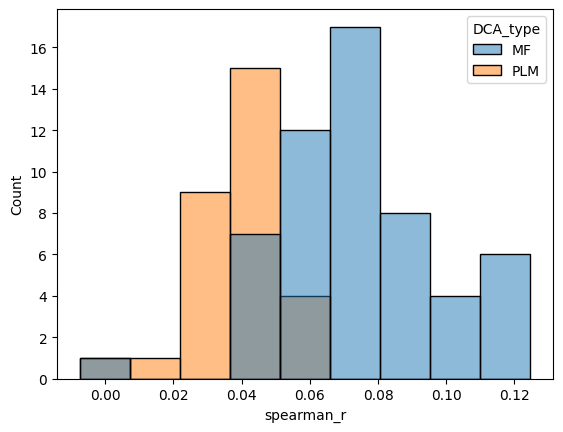

In [13]:
sns.histplot(df_results,
             x = 'spearman_r',
             hue = 'DCA_type')

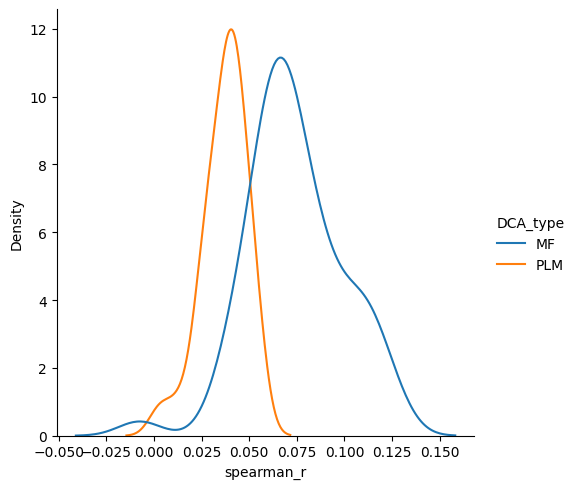

In [15]:
sns.displot(df_results,
            x = 'spearman_r',
            hue = 'DCA_type',
            kind = 'kde')

<Axes: xlabel='dca_score', ylabel='prob'>

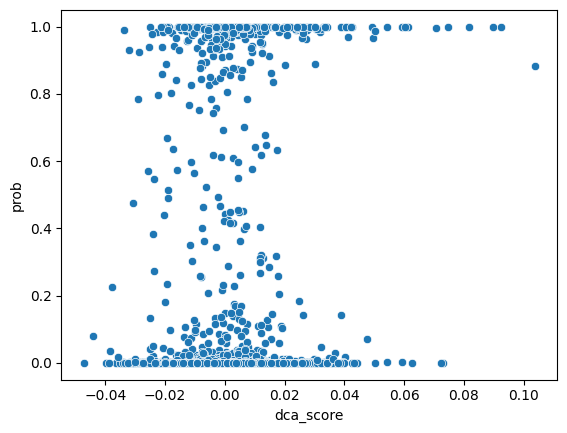

In [19]:
sns.scatterplot(df_esm_plmdca,
                x = 'dca_score',
                y = 'prob')